In [176]:
import pandas as pd

from utils import *
#pd.options.plotting.backend = "plotly"
import pandas as pd 
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt 
from sklearn.ensemble import GradientBoostingRegressor
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
%matplotlib inline 
import numpy as np
plt.rcParams['figure.figsize'] = (50, 4)

import warnings
warnings.filterwarnings(action="ignore")
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

from utils import * # We've added all the functions from the last BLU to the utils.py 

In [59]:
df = pd.read_csv("data/data.csv", index_col="date", parse_dates=True)

In [60]:
df 

,PM2.5,exog
date,,
2013-03-01 00:00:00,4.0,4.4
2013-03-01 01:00:00,8.0,4.7
2013-03-01 02:00:00,7.0,5.6
2013-03-01 03:00:00,6.0,3.1
2013-03-01 04:00:00,3.0,2.0
...,...,...
2017-02-21 19:00:00,NaN,1.4
2017-02-21 20:00:00,NaN,1.5
2017-02-21 21:00:00,NaN,1.1


In [61]:
null_rows = df[df.isnull().any(axis=1)]
null_rows.head(20)

,PM2.5,exog
date,,
2013-05-02 21:00:00,NaN,2.8
2013-05-16 13:00:00,NaN,2.7
2013-06-07 16:00:00,NaN,0.8
2013-06-25 01:00:00,NaN,0.2
2013-06-26 00:00:00,NaN,0.4
2013-08-22 11:00:00,NaN,1.1
2013-09-29 15:00:00,NaN,2.0
2013-10-22 12:00:00,NaN,2.0
2013-11-07 15:00:00,NaN,2.5


In [62]:
#df = build_exog_features(df, 24*7)

In [63]:
df["baseline"] = df['PM2.5'].shift(24*7)

In [64]:
df_ = df.copy()

df_['unique_id']=1

In [65]:
df_ = df_.reset_index(inplace=False)
df_ = df_.rename(columns={'date': 'ds', 'PM2.5': 'y', 'exog': 'trend'})
df_ = df_[['unique_id', 'ds', 'y','trend']]

In [66]:
train = df.iloc[:-24*7]
test1 = df.iloc[-24*7:]
from sklearn.impute import KNNImputer
imputer = KNNImputer() # To obtain better results we may want to have more neighbors, of course that in a real setting
                       # this is a parameter that should be tunned
    
imputed_train = imputer.fit_transform(train) # This may take a bit to run
train = pd.DataFrame(imputed_train, index=train.index, columns=train.columns)


train1 = train.iloc[:-24*7]
val1 = train.iloc[-24*7:]
train_val1 = train


In [67]:

val1

,PM2.5,exog,baseline
date,,,
2017-02-08 00:00:00,113.0,0.2,5.0
2017-02-08 01:00:00,117.0,0.0,5.0
2017-02-08 02:00:00,118.0,1.2,7.0
2017-02-08 03:00:00,118.0,1.7,6.0
2017-02-08 04:00:00,111.0,1.6,8.0
...,...,...,...
2017-02-14 19:00:00,210.0,1.1,110.0
2017-02-14 20:00:00,211.0,0.2,118.0
2017-02-14 21:00:00,227.0,1.0,107.0


In [68]:
df_ = train1.reset_index(inplace=False)
df_['unique_id']=1
df_ = df_.rename(columns={'date': 'ds', 'PM2.5': 'y', 'exog': 'trend'})
df_ = df_[['unique_id', 'ds', 'y','trend']]
df_train_val = df_
df_train_val

,unique_id,ds,y,trend
0,1,2013-03-01 00:00:00,4.0,4.4
1,1,2013-03-01 01:00:00,8.0,4.7
2,1,2013-03-01 02:00:00,7.0,5.6
3,1,2013-03-01 03:00:00,6.0,3.1
4,1,2013-03-01 04:00:00,3.0,2.0
...,...,...,...,...
34555,1,2017-02-07 19:00:00,110.0,1.2
34556,1,2017-02-07 20:00:00,118.0,1.3
34557,1,2017-02-07 21:00:00,107.0,0.8
34558,1,2017-02-07 22:00:00,106.0,0.4


In [69]:
val1

,PM2.5,exog,baseline
date,,,
2017-02-08 00:00:00,113.0,0.2,5.0
2017-02-08 01:00:00,117.0,0.0,5.0
2017-02-08 02:00:00,118.0,1.2,7.0
2017-02-08 03:00:00,118.0,1.7,6.0
2017-02-08 04:00:00,111.0,1.6,8.0
...,...,...,...
2017-02-14 19:00:00,210.0,1.1,110.0
2017-02-14 20:00:00,211.0,0.2,118.0
2017-02-14 21:00:00,227.0,1.0,107.0


In [70]:
val2= val1.copy()
val2 = val2.reset_index(inplace=False)

val2['unique_id']=1
val2 = val2.rename(columns={'date': 'ds', 'PM2.5': 'y', 'exog': 'trend'})
val2 = val2[['unique_id', 'ds', 'y','trend']]
val2=val2.drop(columns='y',axis=1).copy()




In [71]:
val2

,unique_id,ds,trend
0,1,2017-02-08 00:00:00,0.2
1,1,2017-02-08 01:00:00,0.0
2,1,2017-02-08 02:00:00,1.2
3,1,2017-02-08 03:00:00,1.7
4,1,2017-02-08 04:00:00,1.6
...,...,...,...
163,1,2017-02-14 19:00:00,1.1
164,1,2017-02-14 20:00:00,0.2
165,1,2017-02-14 21:00:00,1.0
166,1,2017-02-14 22:00:00,1.0


In [172]:
from statsforecast import StatsForecast
from statsforecast.models import (
    AutoARIMA,
    HoltWinters,
    CrostonClassic as Croston, 
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive
)

season_length = 1
sf = StatsForecast(
    models=[AutoARIMA(season_length=1),SeasonalNaive(season_length=12),HistoricAverage(),HoltWinters(season_length=12)], 
    freq='H', 
    n_jobs=-1
)
sf.fit(df_train_val)


StatsForecast(models=[AutoARIMA,SeasonalNaive,HistoricAverage,HoltWinters])

In [173]:
val3= val1.copy()
val3 = val3.reset_index(inplace=False)

val3['unique_id']=1
val3 = val3.rename(columns={'date': 'ds', 'PM2.5': 'y', 'exog': 'trend'})
val3=val3[['unique_id', 'ds', 'y','trend']]
val3

,unique_id,ds,y,trend
0,1,2017-02-08 00:00:00,113.0,0.2
1,1,2017-02-08 01:00:00,117.0,0.0
2,1,2017-02-08 02:00:00,118.0,1.2
3,1,2017-02-08 03:00:00,118.0,1.7
4,1,2017-02-08 04:00:00,111.0,1.6
...,...,...,...,...
163,1,2017-02-14 19:00:00,210.0,1.1
164,1,2017-02-14 20:00:00,211.0,0.2
165,1,2017-02-14 21:00:00,227.0,1.0
166,1,2017-02-14 22:00:00,247.0,1.0


In [177]:
forecasts = sf.predict(h=168, level=[95],X_df=val2)
forecasts

sf.plot(val3, forecasts)




In [162]:
df_predict = sf.predict(h=168 , X_df=val2)

df_predict

,ds,MSTL
unique_id,,
1,2017-02-08 00:00:00,84.059296
1,2017-02-08 01:00:00,78.572342
1,2017-02-08 02:00:00,96.918716
1,2017-02-08 03:00:00,114.532799
1,2017-02-08 04:00:00,125.763992
...,...,...
1,2017-02-14 19:00:00,57.573750
1,2017-02-14 20:00:00,46.437740
1,2017-02-14 21:00:00,21.834291


In [163]:
df_predict1 = df_predict.copy()

df_predict1.index = pd.to_datetime(df_predict1.ds,infer_datetime_format=True)
df_predict1.index.dtype
df_predict1

,ds,MSTL
ds,,
2017-02-08 00:00:00,2017-02-08 00:00:00,84.059296
2017-02-08 01:00:00,2017-02-08 01:00:00,78.572342
2017-02-08 02:00:00,2017-02-08 02:00:00,96.918716
2017-02-08 03:00:00,2017-02-08 03:00:00,114.532799
2017-02-08 04:00:00,2017-02-08 04:00:00,125.763992
...,...,...
2017-02-14 19:00:00,2017-02-14 19:00:00,57.573750
2017-02-14 20:00:00,2017-02-14 20:00:00,46.437740
2017-02-14 21:00:00,2017-02-14 21:00:00,21.834291


In [164]:
real_val=val1.copy()

In [167]:
real_val['MSTL'] = np.nan
real_val= real_val.fillna(df_predict1)
real_val.tail(24)


,PM2.5,exog,baseline,DynamicOptimizedTheta,MSTL
date,,,,,
2017-02-14 00:00:00,159.0,1.7,40.0,NaN,-23.074995
2017-02-14 01:00:00,137.0,1.7,56.0,NaN,-14.563114
2017-02-14 02:00:00,144.0,0.9,68.0,NaN,-10.987389
2017-02-14 03:00:00,149.0,0.6,70.0,NaN,-4.745334
2017-02-14 04:00:00,148.0,0.7,67.0,NaN,5.961365
2017-02-14 05:00:00,148.0,1.0,66.0,NaN,10.088149
2017-02-14 06:00:00,139.0,0.0,70.0,NaN,11.047291
2017-02-14 07:00:00,151.0,1.4,69.0,NaN,15.038955
2017-02-14 08:00:00,148.0,1.5,76.0,NaN,16.495720


In [168]:
val_mae = mean_absolute_error(real_val["PM2.5"] , real_val["MSTL"])
val_mae

110.55281740121899

<AxesSubplot: xlabel='date'>

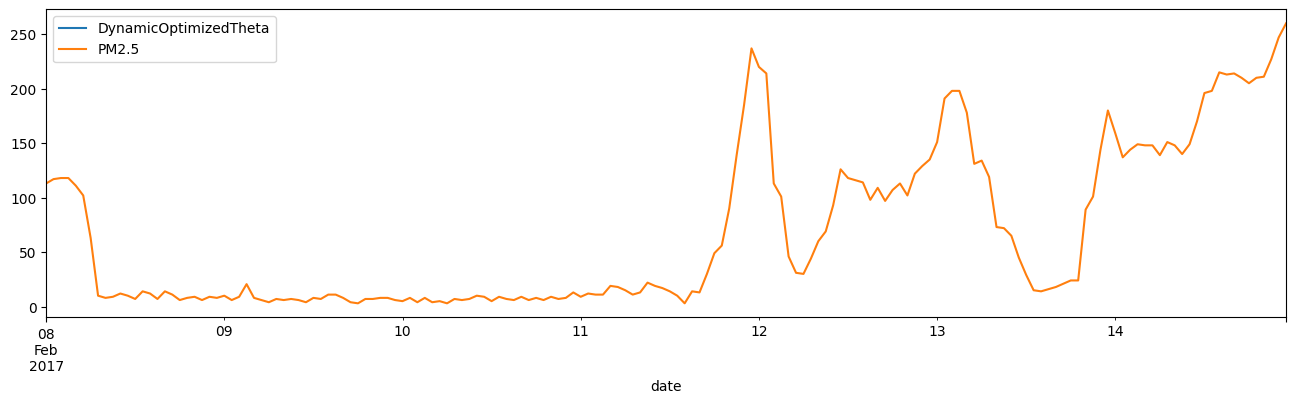

In [169]:
real_val[["DynamicOptimizedTheta","PM2.5"]].plot()